In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds

In [2]:
(dataset_train_original, dataset_validate_original), info = tfds.load(
    "cats_vs_dogs",
    split=["train[:10%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='~/tensorflow_datasets/cats_vs_dogs/4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and

# Look at your beeping data

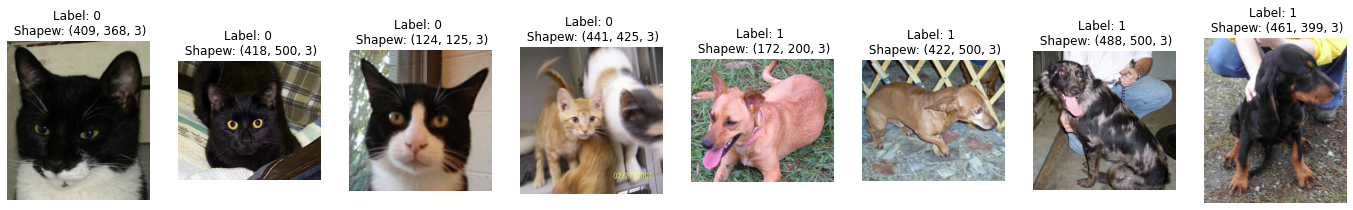

In [3]:
num_samples = 8
index = 1
plt.figure(figsize=(24,4))

for x,y in dataset_train_original.shuffle(100).take(num_samples):
    plt.subplot(1,num_samples, index)
    plt.imshow(x.numpy())
    plt.title(f"Label: {y.numpy()} \n Shapew: {x.numpy().shape}")
    plt.axis("off")
    index +=1

In [4]:
# dir(dataset_train_original)

# Data preprocessing

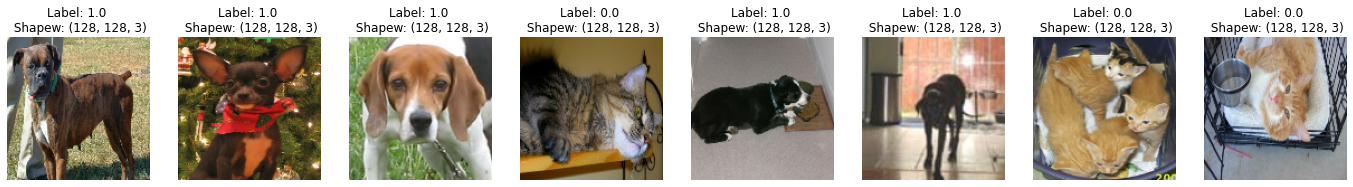

In [5]:
def encode(image, label, image_size=(128,128)):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, image_size)
    label = tf.cast(label, tf.float32)
    return image, label



dataset = dataset_train_original.map(lambda image, label: encode(image, label))

num_samples = 8
index = 1
plt.figure(figsize=(24,4))

for x,y in dataset.take(num_samples):
    plt.subplot(1,num_samples, index)
    plt.imshow(x.numpy())
    plt.title(f"Label: {y.numpy()} \n Shapew: {x.numpy().shape}")
    plt.axis("off")
    index +=1

In [6]:
dataset_train = dataset_train_original.map(lambda image, label: encode(image, label))
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(2500)
dataset_train = dataset_train.batch(128)

dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(128)


In [7]:
history_dict = {}
epochs = 50 

def render_history(history):
    plt.title("Losses")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Accuracies")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

def compare_histories():
    for training_names, history in history_dict.items():
        plt.plot(history["val_accuracy"], label=training_names)
    plt.legend()
    plt.show()
    plt.close()

In [8]:
for training_names, history in history_dict.items():
        plt.plot(history["val_accuracy"], label=training_names)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

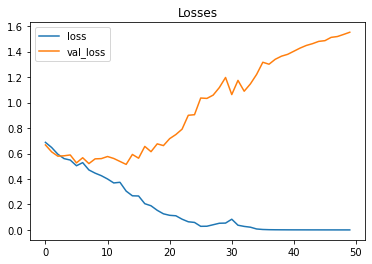

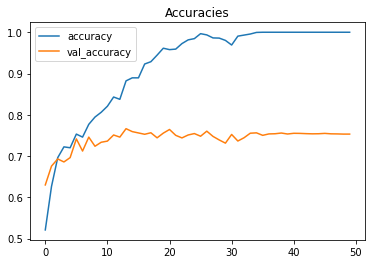

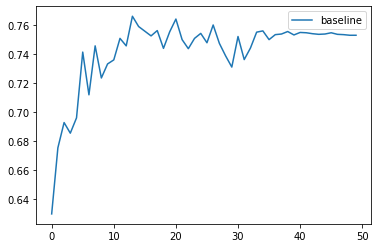

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(
    32,
    (3,3),
    padding="same",
    activation="relu",
    input_shape=(128,128,3)
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    32,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    64,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    64,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    validation_data=dataset_validate,
    epochs=epochs
)

history_dict["baseline"] = history.history
render_history(history)
compare_histories()

# Data Augmentation


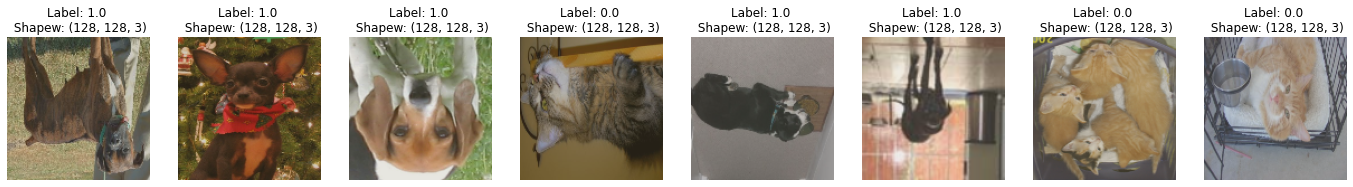

In [10]:
def augment(image, label):
    image_augmented = image
    image_augmented = tf.image.random_flip_left_right(image_augmented)
    image_augmented = tf.image.random_flip_up_down(image_augmented)
    image_augmented = tf.image.random_contrast(image_augmented, 0.5, 1.0)
    return image_augmented, label


dataset = dataset_train_original.map(lambda image, label: encode(image, label))
dataset = dataset.map(lambda image, label: augment(image, label))

num_samples = 8
index = 1
plt.figure(figsize=(24,4))

for x,y in dataset.take(num_samples):
    plt.subplot(1,num_samples, index)
    plt.imshow(x.numpy())
    plt.title(f"Label: {y.numpy()} \n Shapew: {x.numpy().shape}")
    plt.axis("off")
    index +=1

In [11]:
dataset_train_augmented = dataset_train_original.map(lambda image, label: encode(image, label))
dataset_train_augmented = dataset_train_augmented.cache()
dataset_train_augmented = dataset_train_augmented.map(lambda image, label: augment(image, label))
dataset_train_augmented = dataset_train_augmented.shuffle(2500)
dataset_train_augmented = dataset_train_augmented.batch(128)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)      

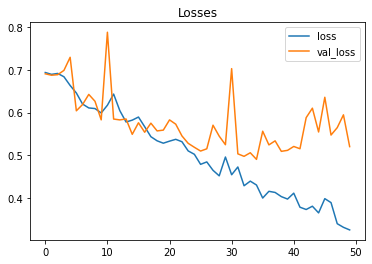

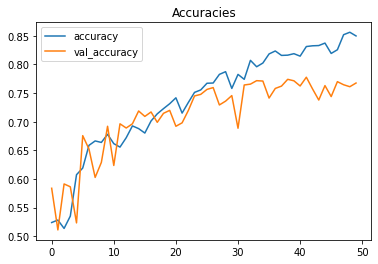

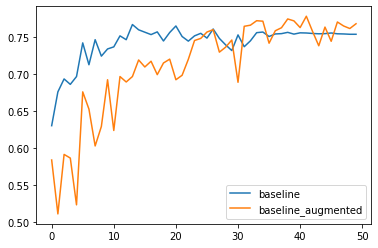

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(
    32,
    (3,3),
    padding="same",
    activation="relu",
    input_shape=(128,128,3)
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    32,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    64,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    64,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train_augmented,
    validation_data=dataset_validate,
    epochs=epochs
)

history_dict["baseline_augmented"] = history.history
render_history(history)
compare_histories()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

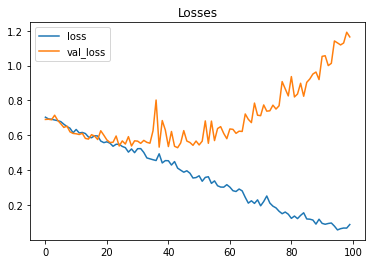

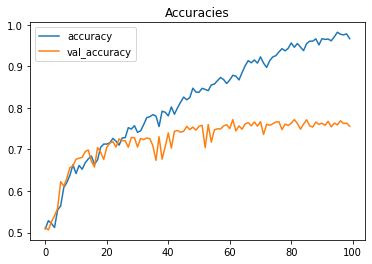

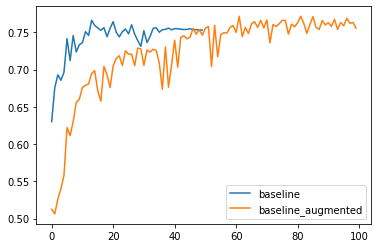

In [13]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(
    32,
    (3,3),
    padding="same",
    activation="relu",
    input_shape=(128,128,3)
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    32,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    64,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    64,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train_augmented,
    validation_data=dataset_validate,
    epochs=100
)

history_dict["baseline_augmented"] = history.history
render_history(history)
compare_histories()

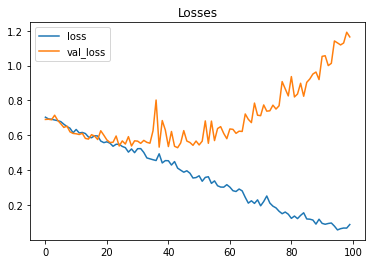

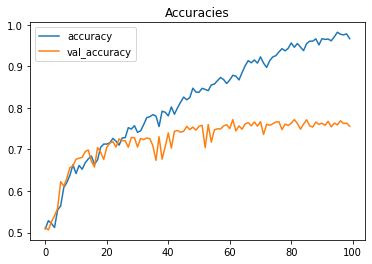

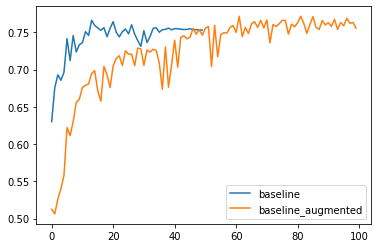

In [14]:

history_dict["baseline_augmented"] = history.history
render_history(history)
compare_histories()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 32)        0

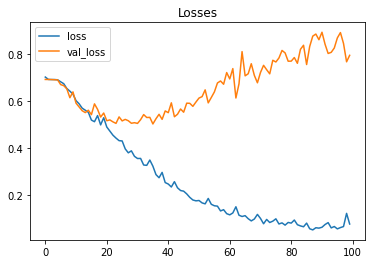

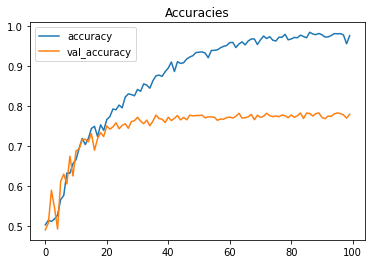

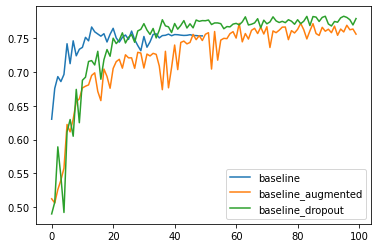

In [15]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(
    32,
    (3,3),
    padding="same",
    activation="relu",
    input_shape=(128,128,3)
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.09))


model.add(layers.Conv2D(
    32,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(
    64,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(
    64,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    validation_data=dataset_validate,
    epochs=100
)

history_dict["baseline_dropout"] = history.history
render_history(history)
compare_histories()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 32)        0

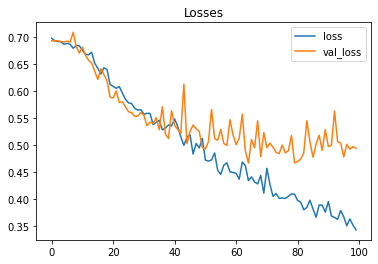

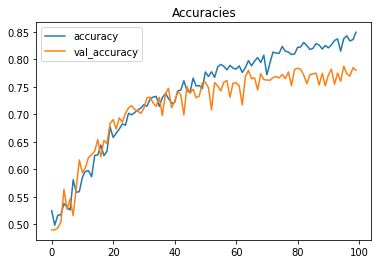

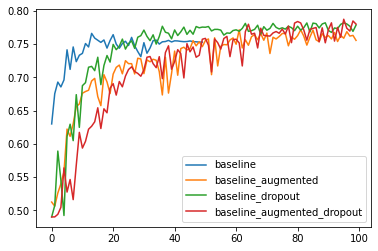

In [16]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(
    32,
    (3,3),
    padding="same",
    activation="relu",
    input_shape=(128,128,3)
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.09))


model.add(layers.Conv2D(
    32,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(
    64,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(
    64,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train_augmented,
    validation_data=dataset_validate,
    epochs=100
)

history_dict["baseline_augmented_dropout"] = history.history
render_history(history)
compare_histories()

In [17]:
tf.keras.backend.clear_session()

base_net = tf.keras.applications.VGG19(
    include_top = False,
    input_shape=(128, 128, 3)
)
# base_net.summary()
base_net.trainable = False

model = models.Sequential()
model.add(base_net)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,073,217
Trainable params: 1,048,833
Non-trainable params: 20,024,384
_________________________________________________________________


Epoch 1/50
19/19 [==============================] - 20s 868ms/step - loss: 0.8959 - accuracy: 0.6032 - val_loss: 0.5120 - val_accuracy: 0.7298
Epoch 2/50
19/19 [==============================] - 13s 690ms/step - loss: 0.4099 - accuracy: 0.8216 - val_loss: 0.3781 - val_accuracy: 0.8323
Epoch 3/50
19/19 [==============================] - 13s 688ms/step - loss: 0.3271 - accuracy: 0.8607 - val_loss: 0.3504 - val_accuracy: 0.8450
Epoch 4/50
19/19 [==============================] - 13s 689ms/step - loss: 0.2814 - accuracy: 0.8835 - val_loss: 0.3377 - val_accuracy: 0.8534
Epoch 5/50
19/19 [==============================] - 13s 683ms/step - loss: 0.2493 - accuracy: 0.9063 - val_loss: 0.3479 - val_accuracy: 0.8482
Epoch 6/50
19/19 [==============================] - 13s 691ms/step - loss: 0.2155 - accuracy: 0.9170 - val_loss: 0.3254 - val_accuracy: 0.8562
Epoch 7/50
19/19 [==============================] - 13s 697ms/step - loss: 0.1869 - accuracy: 0.9359 - val_loss: 0.3219 - val_accuracy: 0.8635

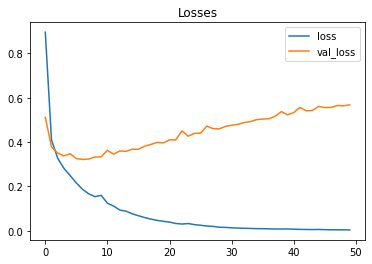

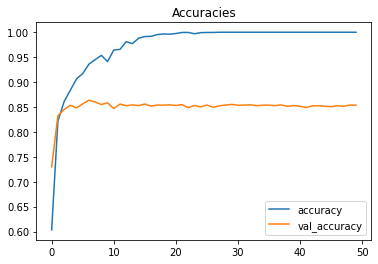

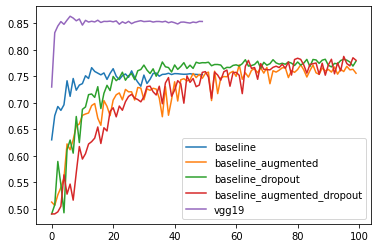

In [18]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    validation_data=dataset_validate,
    epochs=50
)

history_dict["vgg19"] = history.history
render_history(history)
compare_histories()

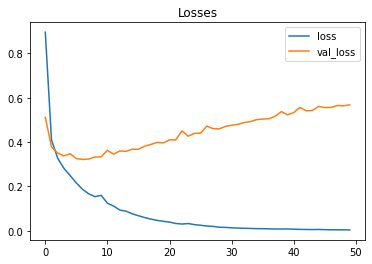

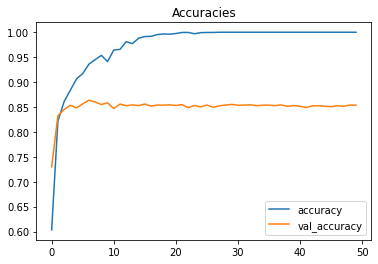

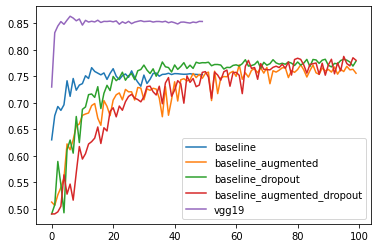

In [19]:
history_dict["vgg19"] = history.history
render_history(history)
compare_histories()

In [22]:
tf.keras.backend.clear_session()

base_net = tf.keras.applications.EfficientNetB0(
    include_top = False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)
# base_net.summary()
base_net.trainable = False

model = models.Sequential()
model.add(base_net)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 128)               2621568   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,671,268
Trainable params: 2,621,697
Non-trainable params: 4,049,571
_________________________________________________________________


Epoch 1/50
19/19 [==============================] - 13s 366ms/step - loss: 1.5257 - accuracy: 0.5271 - val_loss: 0.7441 - val_accuracy: 0.5099
Epoch 2/50
19/19 [==============================] - 5s 246ms/step - loss: 0.7068 - accuracy: 0.5077 - val_loss: 0.7061 - val_accuracy: 0.5099
Epoch 3/50
19/19 [==============================] - 5s 249ms/step - loss: 0.7030 - accuracy: 0.4837 - val_loss: 0.6932 - val_accuracy: 0.4901
Epoch 4/50
19/19 [==============================] - 5s 250ms/step - loss: 0.6931 - accuracy: 0.5150 - val_loss: 0.6932 - val_accuracy: 0.4901
Epoch 5/50
19/19 [==============================] - 5s 247ms/step - loss: 0.6931 - accuracy: 0.5150 - val_loss: 0.6932 - val_accuracy: 0.4901
Epoch 6/50
19/19 [==============================] - 5s 247ms/step - loss: 0.6930 - accuracy: 0.5150 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 7/50
19/19 [==============================] - 5s 249ms/step - loss: 0.6930 - accuracy: 0.5150 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch

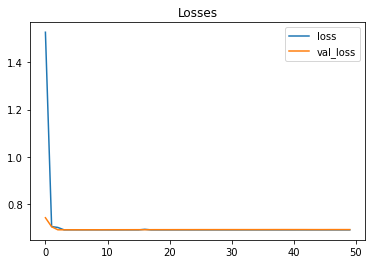

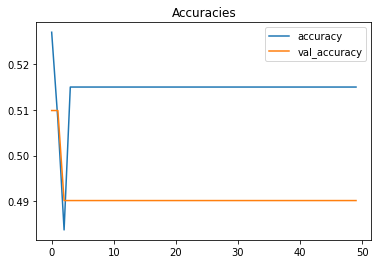

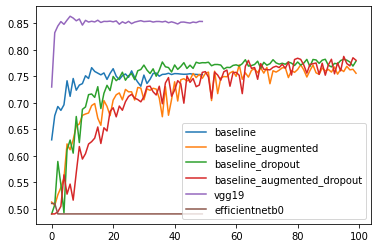

In [23]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    validation_data=dataset_validate,
    epochs=50
)

history_dict["efficientnetb0"] = history.history
render_history(history)
compare_histories()

In [27]:
# DenseNet201

tf.keras.backend.clear_session()

base_net = tf.keras.applications.DenseNet201(
    include_top = False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)
# base_net.summary()

In [25]:
base_net.trainable = False

model = models.Sequential()
model.add(base_net)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 128)               3932288   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22,254,401
Trainable params: 3,932,417
Non-trainable params: 18,321,984
_________________________________________________________________


Epoch 1/50
19/19 [==============================] - 32s 962ms/step - loss: 0.8865 - accuracy: 0.8977 - val_loss: 0.6479 - val_accuracy: 0.9233
Epoch 2/50
19/19 [==============================] - 10s 565ms/step - loss: 0.3160 - accuracy: 0.9566 - val_loss: 0.5131 - val_accuracy: 0.9394
Epoch 3/50
19/19 [==============================] - 10s 572ms/step - loss: 0.1756 - accuracy: 0.9703 - val_loss: 0.2359 - val_accuracy: 0.9542
Epoch 4/50
19/19 [==============================] - 11s 575ms/step - loss: 0.0392 - accuracy: 0.9871 - val_loss: 0.2481 - val_accuracy: 0.9555
Epoch 5/50
19/19 [==============================] - 10s 567ms/step - loss: 0.0174 - accuracy: 0.9957 - val_loss: 0.2603 - val_accuracy: 0.9546
Epoch 6/50
19/19 [==============================] - 10s 571ms/step - loss: 0.0105 - accuracy: 0.9966 - val_loss: 0.2185 - val_accuracy: 0.9615
Epoch 7/50
19/19 [==============================] - 10s 567ms/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 0.2199 - val_accuracy: 0.9622

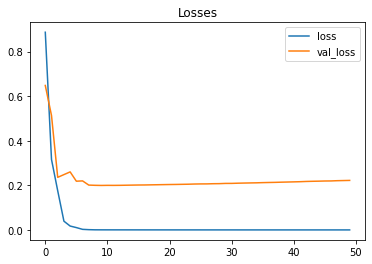

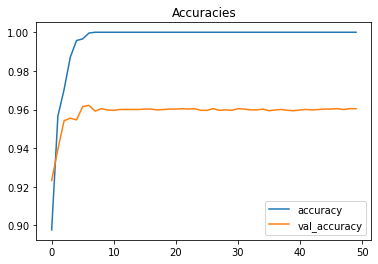

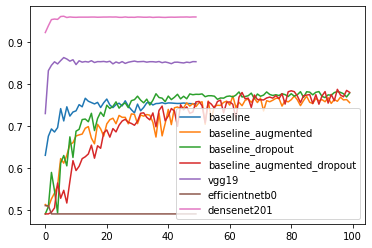

In [26]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    validation_data=dataset_validate,
    epochs=30
)

history_dict["densenet201"] = history.history
render_history(history)
compare_histories()

In [28]:
base_net.trainable = False

model = models.Sequential()
model.add(base_net)
# model.add(layers.Flatten())
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dropout (Dropout)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 128)               3932288   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22,254,401
Trainable params: 3,932,417
Non-trainable params: 18,321,984
_________________________________________________________________


Epoch 1/30
19/19 [==============================] - 23s 728ms/step - loss: 4.0671 - accuracy: 0.7485 - val_loss: 0.1125 - val_accuracy: 0.9544
Epoch 2/30
19/19 [==============================] - 11s 574ms/step - loss: 0.1439 - accuracy: 0.9411 - val_loss: 0.1174 - val_accuracy: 0.9518
Epoch 3/30
19/19 [==============================] - 11s 571ms/step - loss: 0.0976 - accuracy: 0.9604 - val_loss: 0.1018 - val_accuracy: 0.9611
Epoch 4/30
19/19 [==============================] - 11s 572ms/step - loss: 0.0795 - accuracy: 0.9703 - val_loss: 0.0979 - val_accuracy: 0.9609
Epoch 5/30
19/19 [==============================] - 10s 570ms/step - loss: 0.0698 - accuracy: 0.9742 - val_loss: 0.0950 - val_accuracy: 0.9626
Epoch 6/30
19/19 [==============================] - 10s 568ms/step - loss: 0.0575 - accuracy: 0.9798 - val_loss: 0.0961 - val_accuracy: 0.9617
Epoch 7/30
19/19 [==============================] - 11s 575ms/step - loss: 0.0474 - accuracy: 0.9841 - val_loss: 0.0951 - val_accuracy: 0.9626

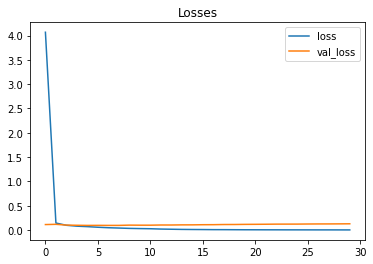

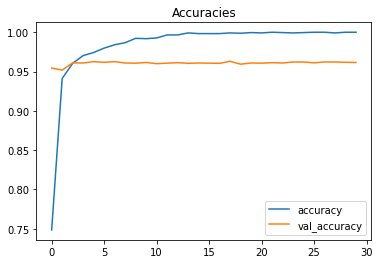

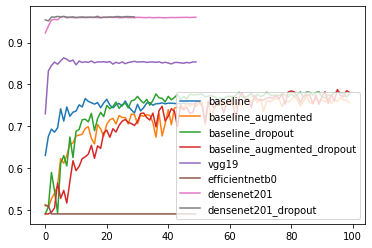

In [29]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    validation_data=dataset_validate,
    epochs=30
)

history_dict["densenet201_dropout"] = history.history
render_history(history)
compare_histories()

In [31]:
# InceptionResNetV2

tf.keras.backend.clear_session()

base_net = tf.keras.applications.InceptionResNetV2(
    include_top = False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)
base_net.summary()

219055592/219055592 [==============================] - 10s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
            

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 128)               786560    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 55,123,425
Trainable params: 786,689
Non-trainable params: 54,336,736
_________________________________________________________________
Epoch 1/30
19/19 [==============================] - 27s 798ms/step - loss: 2.3630 - accuracy: 0.8151 - v

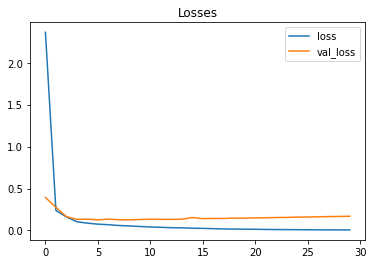

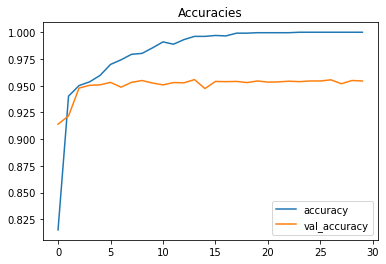

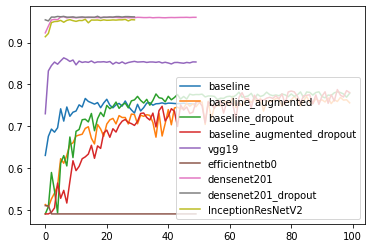

In [32]:
base_net.trainable = False

model = models.Sequential()
model.add(base_net)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    validation_data=dataset_validate,
    epochs=30
)

history_dict["InceptionResNetV2"] = history.history
render_history(history)
compare_histories()